In [1]:
import torch
import diffusers
import transformers
import numpy

vae = diffusers.AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [2]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


#pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, cache_dir="cache/")
#pipe = pipe.to(device)

#prompt = "Radiograph of the left knee, showing tibia, fibula, femur, and patella, , exhibiting mild arthritis"
#image = pipe(prompt).images[0]  
    
#image.save("xray of a knee.png")

In [3]:
#image = pipe(prompt).images[0]  


In [4]:
import diffusers
#vae = diffusers.AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

In [5]:
import preprocess_data
vae.cuda()
0

0

In [6]:
dxas = preprocess_data.dxa_dataset()

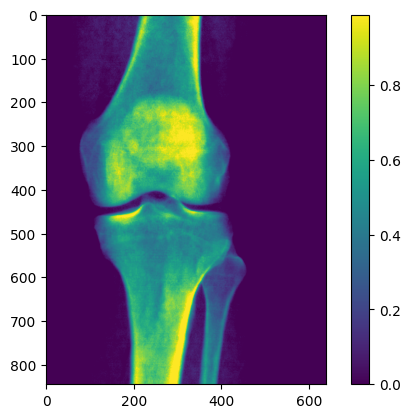

In [7]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(dxas[0][0, 0])
plt.colorbar()

In [166]:
radiographs = preprocess_data.radiograph_dataset()

KeyboardInterrupt: 

In [268]:
unet = diffusers.UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", cache_dir="cache/")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [269]:
unet.cuda()
0

0

In [270]:
activation = {}
def get_activation(name, layer):
    def hook(model, input, output):
        activation[name] = output.detach().cpu()
    layer.register_forward_hook(hook)

get_activation("ups", unet.up_blocks[0].upsamplers[0].conv)
    
    

In [271]:
def latents(image):
    dx= image
    dx = torch.cat([dx,dx,dx], axis=1).float()
    latents = vae.encode(dx.cuda()).latent_dist.sample()*vae.config.scaling_factor
    noise_pred = unet(latents, encoder_hidden_states=torch.zeros(1, 1, 768).cuda(),timestep=.5,).sample
    return activation["ups"]

def random_latents(image):

    outputs = []
    for i in range(10):
        
        theta = torch.randn(3, 3) / 5
    
        qq = AffineParameterNet()
        with torch.no_grad():
            qq.angle[:] = theta

        qq.assign_identity_map(image.shape)

        warped_img = qq.as_function(image)(qq(image, None)(qq.identity_map))

        warped_latents = latents(warped_img)

        with torch.no_grad():
            qq.angle[:] = -theta
        qq.assign_identity_map(warped_latents.shape)
        l = qq.as_function(warped_latents)(qq(image, None)(qq.identity_map))

        outputs.append(l)
    return torch.mean(torch.cat(outputs, 0), 0, keepdims=True)
random_latents(ra.float()).shape

    
    

torch.Size([1, 1280, 27, 20])

In [290]:
ra = torch.flip(radiographs[0][40:41], dims=[-1])
da = dxas[0][40:41]

In [291]:
ra_latents = random_latents(ra.float()).detach()
da_latents = random_latents(da).detach()

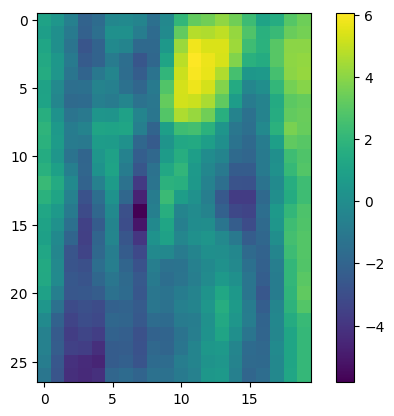

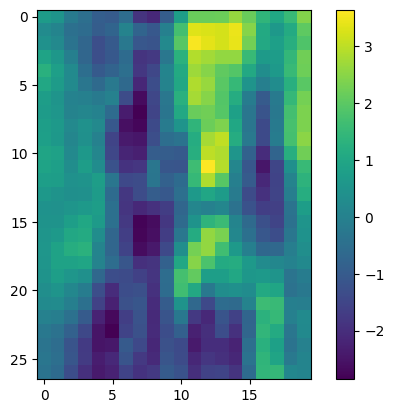

In [292]:
channel = 80

plt.imshow(ra_latents[0, channel].cpu())
plt.colorbar()
plt.show()
plt.imshow(da_latents[0, channel].cpu())
plt.colorbar()
plt.show()

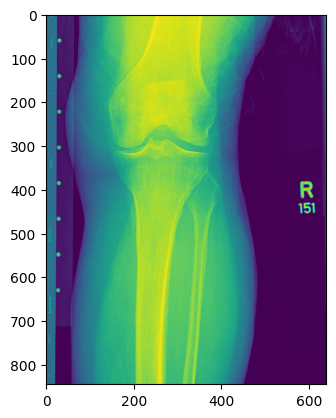

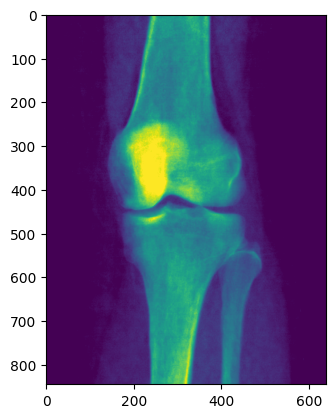

In [293]:
plt.imshow(ra[0, 0])
plt.show()
plt.imshow(da[0, 0])
plt.show()

In [307]:

from icon_registration import losses
import torch
import torch.nn.functional as F
import icon_registration as icon
import numpy as np
import matplotlib.pyplot as plt


class AffineParameterNet(icon.RegistrationModule):
    def __init__(self):
        super().__init__()
        self.angle = torch.nn.Parameter(torch.zeros(3, 3).float())
    def forward(self, A, B):
        def warp(coords):
            coords = coords - .5
            coords = torch.cat([coords, torch.ones(coords.shape[0], 1, coords.shape[2], coords.shape[3], device=A.device)], axis=1)
            mask = torch.tensor([[1, 1, 0], [1, 1, 0], [0, 0, 0]]).float().to(A.device)
            scale = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 0]]).float().to(A.device)
            coords = torch.einsum("bfxy,of->boxy", coords, torch.linalg.matrix_exp(scale * self.angle[0, 0] + self.angle - 1 *mask* torch.permute(self.angle, [1, 0])))
            return coords[:, :2] + .5
        return warp
    def set_angle(self, theta):
        with torch.no_grad():
            self.angle = torch.nn.Parameter(torch.zeros(3, 3).float())
            self.angle[0, 1] = theta
            self.angle[1, 0] = -theta

class LNCCOnlyInterpolated(icon.losses.SimilarityBase):                                                                           
    def __init__(self, sigma):                                                                                        
        super().__init__(isInterpolated=True)                                                                         
        self.sigma = sigma                                                                                            
                                                                                                                      
    def blur(self, tensor):                                                                                           
        return icon.losses.gaussian_blur(tensor, self.sigma * 4 + 1, self.sigma)                                                  
                                                                                                                      
    def __call__(self, image_A, image_B):                                                                             
                                                                                                                      
        I = image_A[:, :-1]                                                                                           
        J = image_B                                                                                                   
                                                                                                                      
        assert I.shape == J.shape, "The shape of image I and J sould be the same."                                    
        lncc_everywhere = 1 - (                                                                                       
            self.blur(I * J) - (self.blur(I) * self.blur(J))                                                          
        ) / torch.sqrt(                                                                                               
            (self.blur(I * I) - self.blur(I) ** 2 + 0.00001)                                                          
            * (self.blur(J * J) - self.blur(J) ** 2 + 0.00001)                                                        
        )                                                                                                             
                                                                                                                      
        with torch.no_grad():                                                                                         
            A_inbounds = image_A[:, -1:]                                                                              
                                                                                                                      
            inbounds_mask = self.blur(A_inbounds) > 0.999                                                             
                                                                                                                      
        if len(image_A.shape) - 2 == 3:                                                                               
            dimensions_to_sum_over = [2, 3, 4]                                                                        
        elif len(image_A.shape) - 2 == 2:                                                                             
            dimensions_to_sum_over = [2, 3]                                                                           
        elif len(image_A.shape) - 2 == 1:                                                                             
            dimensions_to_sum_over = [2]      

                                                                                                                      
        lncc_loss = torch.sum(                                                                                        
            inbounds_mask * lncc_everywhere, dimensions_to_sum_over                                                   
        ) / torch.sum(inbounds_mask, dimensions_to_sum_over)                                                          
                                                                                                                      
        return torch.mean(lncc_loss)  

class CenterSimilarity(icon.losses.BendingEnergyNet):                                                                 
    def compute_similarity_measure(self, phi_AB_vectorfield, image_A, image_B):                                       
                                                                                                                      
        trim = 5                                                                                                    
                                                                                                                      
        if getattr(self.similarity, "isInterpolated", False):                                                         
            # tag images during warping so that the similarity measure                                                
            # can use information about whether a sample is interpolated                                              
            # or extrapolated                                                                                         
            inbounds_tag = torch.zeros([image_A.shape[0]] + [1] + list(image_A.shape[2:]), device=image_A.device)     
            if len(self.input_shape) - 2 == 3:                                                                        
                inbounds_tag[:, :, trim:-trim, trim:-trim, trim:-trim] = 1.0                                          
            elif len(self.input_shape) - 2 == 2:                                                                      
                inbounds_tag[:, :, trim:-trim, trim:-trim] = 1.0                                                      
            else:                                                                                                     
                inbounds_tag[:, :, trim:-trim] = 1.0                                                                  
        else:                                                                                                         
            inbounds_tag = None                                                                                       
                                                                                                                      
        self.warped_image_A = self.as_function(                                                                       
            torch.cat([image_A, inbounds_tag], axis=1) if inbounds_tag is not None else image_A                       
        )(phi_AB_vectorfield)                                                                                         
                                                                                                                      
        similarity_loss = self.similarity(                                                                            
            self.warped_image_A, image_B                                                                              
        )                                                                                                             
        return similarity_loss   



def optim(net, params, A, B):
    net.assign_identity_map(A.shape)
    net.cuda()
    A = A.cuda() 
    B = B.cuda()
    o = torch.optim.Adam(params, lr=0.014)
    for i in range(18):
        print(params[0])
        for j in range(19):
            o.zero_grad()
            loss = net(A, B)
            
            loss.all_loss.backward()
            o.step()

net = icon.losses.DiffusionRegularizedNet(AffineParameterNet(), icon.losses.LNCCOnlyInterpolated(3), 0.0)

net.assign_identity_map(ra_latents.shape)

net.cuda()

   
params = list(net.parameters())

optim(net, params, ra_latents.float(), da_latents)


Parameter containing:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0631,  0.0725, -0.1748],
        [-0.0725,  0.0000, -0.0841],
        [ 0.1592, -0.0501,  0.0579]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.1439,  0.0839, -0.1631],
        [-0.0839,  0.0000, -0.0715],
        [ 0.1976, -0.0421, -0.0288]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.1242,  0.0571, -0.1641],
        [-0.0571,  0.0000, -0.0747],
        [ 0.3066, -0.0010, -0.0449]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.1315,  0.0520, -0.1687],
        [-0.0520,  0.0000, -0.0775],
        [ 0.4956,  0.0651, -0.0440]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.1239,  0.0556, -0.1695],
        [-0.0556,  0.0000, -0.0762],
        [ 0.6295,  0.1013, -0.0447]], device='cuda:0', requires_grad=True)
Parameter containin

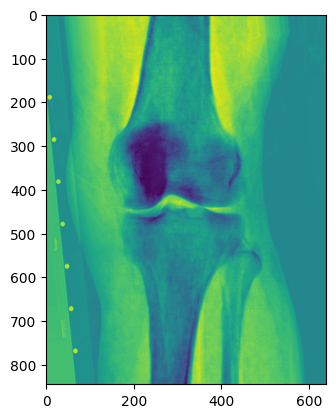

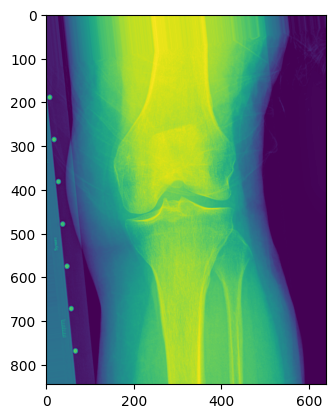

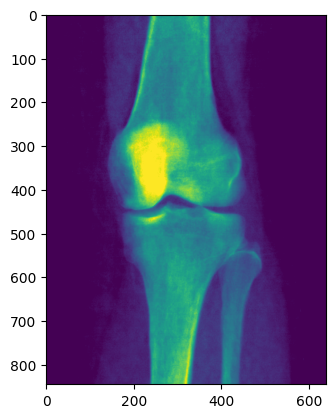

In [308]:
x = icon.RegistrationModule()
x.assign_identity_map(ra.shape)
warped_ra = x.as_function(ra.float())(net.phi_AB(x.identity_map.cuda()).cpu().detach())[0, 0]
#plt.imshow(ra[0, 0] - da[0, 0])
#plt.show()

plt.imshow(warped_ra - da[0, 0])
plt.show()
plt.imshow(warped_ra)
plt.show()
plt.imshow(da[0, 0])

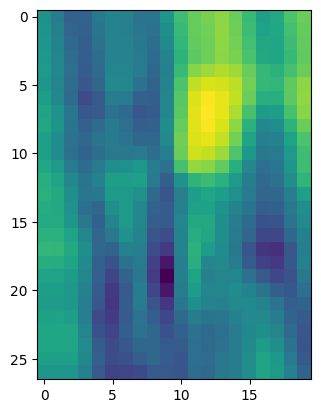

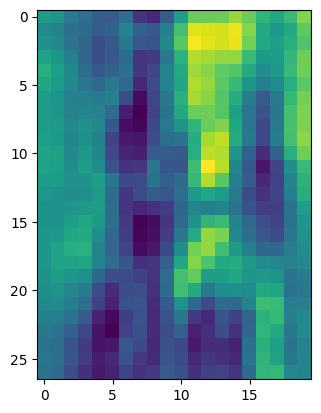

In [306]:
plt.imshow(net.warped_image_A[0, channel].cpu().detach())
plt.show()
plt.imshow(da_latents[0, channel])

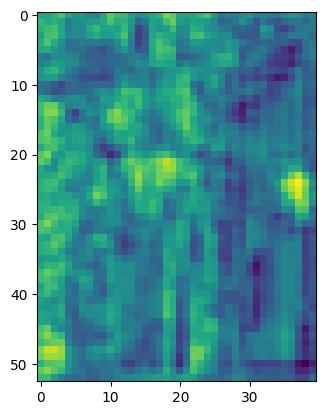

In [99]:
plt.imshow(ra_latents[0, 0])

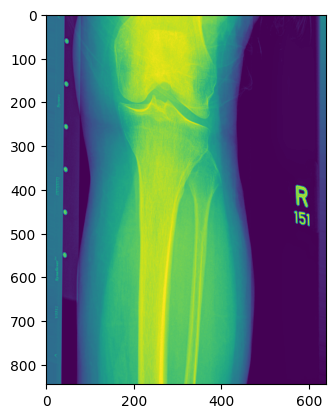